
# Solving ODEs Using Monte Carlo Methods

This notebook demonstrates how to solve ordinary differential equations (ODEs) using Monte Carlo methods, specifically **importance sampling** and **quasi-Monte Carlo techniques**.

We focus on the linear ODE:

\begin{equation}
\frac{dy}{dt} = -2y, \quad y(0) = 1
\end{equation}

The exact analytical solution is:

\begin{equation}
y(t) = e^{-2t}
\end{equation}

## Why Monte Carlo for ODEs?

Monte Carlo methods are typically used for stochastic integration. Here, we extend this idea to ODEs by interpreting the integration step in ODE solvers (like Euler or Runge-Kutta) as an expectation. This allows us to use sampling-based approaches to approximate the solution.

### Importance Sampling

Importance sampling involves drawing samples from a distribution that emphasizes important regions of the domain (where the integrand is large), and adjusting the weight of each sample accordingly.

### Quasi-Monte Carlo

Instead of random samples, quasi-Monte Carlo methods use low-discrepancy sequences (e.g., Sobol, Halton) to improve convergence rates.

We'll now implement the Monte Carlo solution and compare it with the analytical solution and `SciPy`'s built-in ODE solver.


In [22]:

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Add project directory to path
project_dir = os.getcwd()
sys.path.append(project_dir)

# Import modules
from mc_ode_solver.solver import MonteCarloODESolver
from mc_ode_solver.benchmarks import linear_ode


Adjust `num_samples` to visualize the effect of sample size

In [ ]:

# Monte Carlo Solver Parameters
y0 = 1.0
t_span = (0, 2)
num_samples = 10 #5/50/100/1000 <<< TRY ME >>>

# Monte Carlo solution
solver = MonteCarloODESolver(linear_ode, y0, t_span, method='importance_sampling', num_samples=num_samples)
t_vals, solutions = solver.solve()

# Analytical solution: y = e^(-2t)
analytical = y0 * np.exp(-2 * t_vals)

# SciPy reference solution
scipy_sol = solve_ivp(linear_ode, t_span, [y0], t_eval=t_vals)


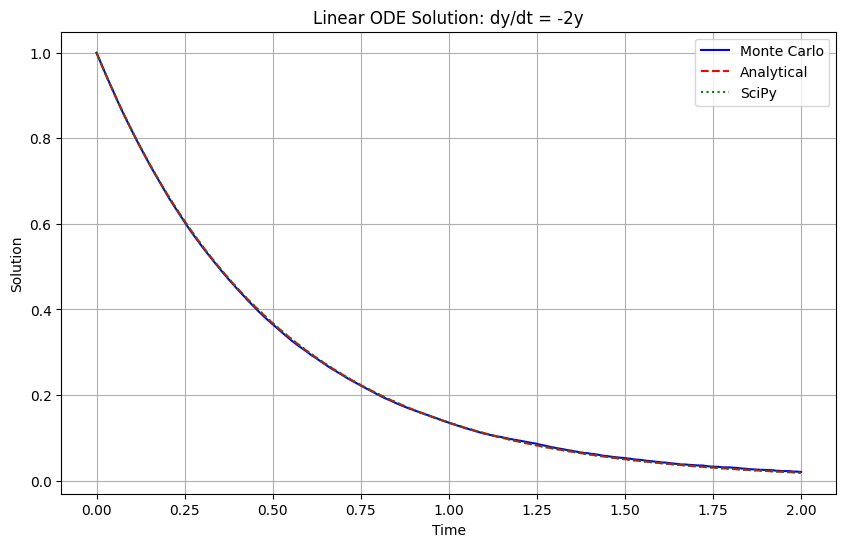

Mean absolute error: 0.001813


In [24]:

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t_vals, solutions, 'b-', label='Monte Carlo')
plt.plot(t_vals, analytical, 'r--', label='Analytical')
plt.plot(t_vals, scipy_sol.y[0], 'g:', label='SciPy')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Linear ODE Solution: dy/dt = -2y')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print mean absolute error
mc_error = np.mean(np.abs(solutions - analytical))
print(f"Mean absolute error: {mc_error:.6f}")



# Extended Theory: Monte Carlo for Differential Equations

Traditionally, we solve initial value problems (IVPs) of the form:

$\frac{dy}{dt} = f(t, y), \quad y(t_0) = y_0$

using deterministic integrators. But in a Monte Carlo framework, we approximate the update rule:

$y_{n+1} = y_n + \int_{t_n}^{t_{n+1}} f(t, y(t)) dt$

using stochastic samples. The motivation here is two-fold:

1. **Stochastic Modeling**: Many real-world systems are inherently noisy or uncertain.
2. **High-dimensional Systems**: Monte Carlo methods scale better with dimensionality compared to grid-based methods.

We reinterpret the integral in the Euler method as an expectation:

$y_{n+1} \approx y_n + \mathbb{E}_{\xi}[f(t_n, y_n, \xi)] \cdot \Delta t$

where $\xi$ is a random perturbation or sample from a proposal distribution.

## Importance Sampling (IS)

In IS, we draw samples \(\{$x_i$\}\) from a proposal distribution \($q(x)$\) and reweight them to estimate expectations under a target distribution \($p(x)$\):

$\mathbb{E}_{p}[h(x)] = \int h(x) \frac{p(x)}{q(x)} q(x) dx \approx \sum_{i=1}^{N} h(x_i) w_i, \quad w_i = \frac{p(x_i)}{q(x_i)}$

In our ODE context, we simulate weighted perturbations to the numerical step, adjusting based on proximity to the current state.

## Quasi-Monte Carlo (QMC)

QMC replaces random sampling with deterministic **low-discrepancy sequences** to ensure a more uniform coverage of the domain.

This often leads to faster convergence compared to vanilla Monte Carlo:

- Monte Carlo: \($\mathcal{O}(N^{-1/2})$\)
- QMC: \($\mathcal{O}(N^{-1} \log^d N)$\) in ideal conditions

## Extended Example: Sinusoidal Forcing

Let's now consider a **nonlinear ODE** with a sinusoidal component:

$\frac{dy}{dt} = -y + \sin(t), \quad y(0) = 0$

The analytical solution is:

$y(t) = \frac{1}{2}( \sin(t) - \cos(t) + e^{-t} )$

We'll solve this using the Monte Carlo solver and compare it against the true solution.


In [25]:

# New benchmark ODE: dy/dt = -y + sin(t)
def sinusoidal_ode(t, y):
    return -y + np.sin(t)

# True analytical solution
def sinusoidal_analytical(t):
    return 0.5 * (np.sin(t) - np.cos(t) + np.exp(-t))


In [ ]:

# Solve using Monte Carlo
y0_sin = 0.0
t_span_sin = (0, 10)
num_samples_sin = 10 #5/50/100/1000 <<< TRY ME >>>

solver_sin = MonteCarloODESolver(sinusoidal_ode, y0_sin, t_span_sin, method='quasi_monte_carlo', num_samples=num_samples_sin)
t_vals_sin, mc_sol_sin = solver_sin.solve()

# Analytical
true_sol = sinusoidal_analytical(t_vals_sin)

# SciPy for reference
scipy_sol_sin = solve_ivp(sinusoidal_ode, t_span_sin, [y0_sin], t_eval=t_vals_sin)


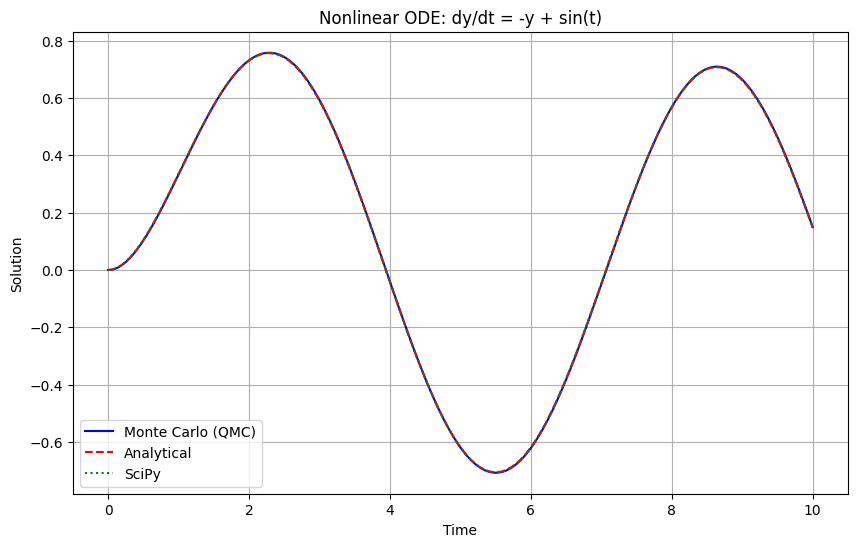

Mean absolute error (sinusoidal): 0.001502


In [27]:

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t_vals_sin, mc_sol_sin, 'b-', label='Monte Carlo (QMC)')
plt.plot(t_vals_sin, true_sol, 'r--', label='Analytical')
plt.plot(t_vals_sin, scipy_sol_sin.y[0], 'g:', label='SciPy')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Nonlinear ODE: dy/dt = -y + sin(t)')
plt.legend()
plt.grid(True)
plt.show()

# Error
mc_error_sin = np.mean(np.abs(mc_sol_sin - true_sol))
print(f"Mean absolute error (sinusoidal): {mc_error_sin:.6f}")
